<a href="https://colab.research.google.com/github/HKAB/ML-Project-Traffic-Flow-Forecasting/blob/main/ASTGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/traffic_data

/content/drive/.shortcut-targets-by-id/1KuB5yZOxUbBW-9aYL0DYL8DGOVL_Ry1c/traffic_data


In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.6 MB/s 


In [ ]:
import os
import numpy as np


def re_normalization(x, mean, std):
    x = x * std + mean
    return x


def max_min_normalization(x, _max, _min):
    x = 1. * (x - _min)/(_max - _min)
    x = x * 2. - 1.
    return x


def re_max_min_normalization(x, _max, _min):
    x = (x + 1.) / 2.
    x = 1. * x * (_max - _min) + _min
    return x
    

def search_data(sequence_length, num_of_depend, label_start_idx,
                num_for_predict, units, points_per_hour):
    '''
    Parameters
    ----------
    sequence_length: int, length of all history data
    num_of_depend: int,
    label_start_idx: int, the first index of predicting target
    num_for_predict: int, the number of points will be predicted for each sample
    units: int, week: 7 * 24, day: 24, recent(hour): 1
    points_per_hour: int, number of points per hour, depends on data
    Returns
    ----------
    list[(start_idx, end_idx)]
    '''

    if points_per_hour < 0:
        raise ValueError("points_per_hour should be greater than 0!")

    if label_start_idx + num_for_predict > sequence_length:
        return None

    x_idx = []
    for i in range(1, num_of_depend + 1):
        start_idx = label_start_idx - points_per_hour * units * i
        end_idx = start_idx + num_for_predict
        if start_idx >= 0:
            x_idx.append((start_idx, end_idx))
        else:
            return None

    if len(x_idx) != num_of_depend:
        return None

    return x_idx[::-1]


def get_sample_indices(data_sequence, num_of_weeks, num_of_days, num_of_hours,
                       label_start_idx, num_for_predict, points_per_hour=12):
    '''
    Parameters
    ----------
    data_sequence: np.ndarray
                   shape is (sequence_length, num_of_vertices, num_of_features)
    num_of_weeks, num_of_days, num_of_hours: int
    label_start_idx: int, the first index of predicting target, 预测值开始的那个点
    num_for_predict: int,
                     the number of points will be predicted for each sample
    points_per_hour: int, default 12, number of points per hour
    Returns
    ----------
    week_sample: np.ndarray
                 shape is (num_of_weeks * points_per_hour,
                           num_of_vertices, num_of_features)
    day_sample: np.ndarray
                 shape is (num_of_days * points_per_hour,
                           num_of_vertices, num_of_features)
    hour_sample: np.ndarray
                 shape is (num_of_hours * points_per_hour,
                           num_of_vertices, num_of_features)
    target: np.ndarray
            shape is (num_for_predict, num_of_vertices, num_of_features)
    '''
    week_sample, day_sample, hour_sample = None, None, None

    if label_start_idx + num_for_predict > data_sequence.shape[0]:
        return week_sample, day_sample, hour_sample, None

    if num_of_weeks > 0:
        week_indices = search_data(data_sequence.shape[0], num_of_weeks,
                                   label_start_idx, num_for_predict,
                                   7 * 24, points_per_hour)
        if not week_indices:
            return None, None, None, None

        week_sample = np.concatenate([data_sequence[i: j]
                                      for i, j in week_indices], axis=0)

    if num_of_days > 0:
        day_indices = search_data(data_sequence.shape[0], num_of_days,
                                  label_start_idx, num_for_predict,
                                  24, points_per_hour)
        if not day_indices:
            return None, None, None, None

        day_sample = np.concatenate([data_sequence[i: j]
                                     for i, j in day_indices], axis=0)

    if num_of_hours > 0:
        hour_indices = search_data(data_sequence.shape[0], num_of_hours,
                                   label_start_idx, num_for_predict,
                                   1, points_per_hour)
        if not hour_indices:
            return None, None, None, None

        hour_sample = np.concatenate([data_sequence[i: j]
                                      for i, j in hour_indices], axis=0)

    target = data_sequence[label_start_idx: label_start_idx + num_for_predict]

    return week_sample, day_sample, hour_sample, target


def read_and_generate_dataset(graph_signal_matrix_filename,
                                                     num_of_weeks, num_of_days,
                                                     num_of_hours, num_for_predict,
                                                     points_per_hour=12, save=False):
    '''
    Parameters
    ----------
    graph_signal_matrix_filename: str, path of graph signal matrix file
    num_of_weeks, num_of_days, num_of_hours: int
    num_for_predict: int
    points_per_hour: int, default 12, depends on data
    Returns
    ----------
    feature: np.ndarray,
             shape is (num_of_samples, num_of_depend * points_per_hour,
                       num_of_vertices, num_of_features)
    target: np.ndarray,
            shape is (num_of_samples, num_of_vertices, num_for_predict)
    '''
    data_seq = np.load(graph_signal_matrix_filename)['data']  # (sequence_length, num_of_vertices, num_of_features)

    all_samples = []
    for idx in range(data_seq.shape[0]):
        sample = get_sample_indices(data_seq, num_of_weeks, num_of_days,
                                    num_of_hours, idx, num_for_predict,
                                    points_per_hour)
        if ((sample[0] is None) and (sample[1] is None) and (sample[2] is None)):
            continue

        week_sample, day_sample, hour_sample, target = sample

        sample = []  # [(week_sample),(day_sample),(hour_sample),target,time_sample]

        if num_of_weeks > 0:
            week_sample = np.expand_dims(week_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(week_sample)

        if num_of_days > 0:
            day_sample = np.expand_dims(day_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(day_sample)

        if num_of_hours > 0:
            hour_sample = np.expand_dims(hour_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(hour_sample)

        target = np.expand_dims(target, axis=0).transpose((0, 2, 3, 1))[:, :, 0, :]  # (1,N,T)
        sample.append(target)

        time_sample = np.expand_dims(np.array([idx]), axis=0)  # (1,1)
        sample.append(time_sample)

        all_samples.append(
            sample)  # sampe：[(week_sample),(day_sample),(hour_sample),target,time_sample] = [(1,N,F,Tw),(1,N,F,Td),(1,N,F,Th),(1,N,Tpre),(1,1)]

    split_line1 = int(len(all_samples) * 0.6)
    split_line2 = int(len(all_samples) * 0.8)

    training_set = [np.concatenate(i, axis=0)
                    for i in zip(*all_samples[:split_line1])]  # [(B,N,F,Tw),(B,N,F,Td),(B,N,F,Th),(B,N,Tpre),(B,1)]
    validation_set = [np.concatenate(i, axis=0)
                      for i in zip(*all_samples[split_line1: split_line2])]
    testing_set = [np.concatenate(i, axis=0)
                   for i in zip(*all_samples[split_line2:])]

    train_x = np.concatenate(training_set[:-2], axis=-1)  # (B,N,F,T')
    val_x = np.concatenate(validation_set[:-2], axis=-1)
    test_x = np.concatenate(testing_set[:-2], axis=-1)

    train_target = training_set[-2]  # (B,N,T)
    val_target = validation_set[-2]
    test_target = testing_set[-2]

    train_timestamp = training_set[-1]  # (B,1)
    val_timestamp = validation_set[-1]
    test_timestamp = testing_set[-1]

    (stats, train_x_norm, val_x_norm, test_x_norm) = normalization(train_x, val_x, test_x)

    all_data = {
        'train': {
            'x': train_x_norm,
            'target': train_target,
            'timestamp': train_timestamp,
        },
        'val': {
            'x': val_x_norm,
            'target': val_target,
            'timestamp': val_timestamp,
        },
        'test': {
            'x': test_x_norm,
            'target': test_target,
            'timestamp': test_timestamp,
        },
        'stats': {
            '_mean': stats['_mean'],
            '_std': stats['_std'],
        }
    }
    print('train x:', all_data['train']['x'].shape)
    print('train target:', all_data['train']['target'].shape)
    print('train timestamp:', all_data['train']['timestamp'].shape)
    print()
    print('val x:', all_data['val']['x'].shape)
    print('val target:', all_data['val']['target'].shape)
    print('val timestamp:', all_data['val']['timestamp'].shape)
    print()
    print('test x:', all_data['test']['x'].shape)
    print('test target:', all_data['test']['target'].shape)
    print('test timestamp:', all_data['test']['timestamp'].shape)
    print()
    print('train data _mean :', stats['_mean'].shape, stats['_mean'])
    print('train data _std :', stats['_std'].shape, stats['_std'])

    if save:
        file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
        dirpath = os.path.dirname(graph_signal_matrix_filename)
        filename = os.path.join(dirpath, file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) + '_astcgn'
        print('save file:', filename)
        np.savez_compressed(filename,
                            train_x=all_data['train']['x'], train_target=all_data['train']['target'],
                            train_timestamp=all_data['train']['timestamp'],
                            val_x=all_data['val']['x'], val_target=all_data['val']['target'],
                            val_timestamp=all_data['val']['timestamp'],
                            test_x=all_data['test']['x'], test_target=all_data['test']['target'],
                            test_timestamp=all_data['test']['timestamp'],
                            mean=all_data['stats']['_mean'], std=all_data['stats']['_std']
                            )
    return all_data


def normalization(train, val, test):
    '''
    Parameters
    ----------
    train, val, test: np.ndarray (B,N,F,T)
    Returns
    ----------
    stats: dict, two keys: mean and std
    train_norm, val_norm, test_norm: np.ndarray,
                                     shape is the same as original
    '''

    assert train.shape[1:] == val.shape[1:] and val.shape[1:] == test.shape[1:]  # ensure the num of nodes is the same
    mean = train.mean(axis=(0,1,3), keepdims=True)
    std = train.std(axis=(0,1,3), keepdims=True)
    print('mean.shape:',mean.shape)
    print('std.shape:',std.shape)

    def normalize(x):
        return (x - mean) / std

    train_norm = normalize(train)
    val_norm = normalize(val)
    test_norm = normalize(test)

    return {'_mean': mean, '_std': std}, train_norm, val_norm, test_norm

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.sparse.linalg import eigs

def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    Parameters
    ----------
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    ----------
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:

        adj_mx = np.load(distance_df_filename)

        return adj_mx, None

    else:

        import csv

        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),
                     dtype=np.float32)

        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)),
                            dtype=np.float32)

        if id_filename:

            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))} 

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA


def scaled_Laplacian(W):
    '''
    compute \tilde{L}
    Parameters
    ----------
    W: np.ndarray, shape is (N, N), N is the num of vertices
    Returns
    ----------
    scaled_Laplacian: np.ndarray, shape (N, N)
    '''

    assert W.shape[0] == W.shape[1]

    D = np.diag(np.sum(W, axis=1))

    L = D - W

    lambda_max = eigs(L, k=1, which='LR')[0].real

    return (2 * L) / lambda_max - np.identity(W.shape[0])


def cheb_polynomial(L_tilde, K):
    '''
    compute a list of chebyshev polynomials from T_0 to T_{K-1}
    Parameters
    ----------
    L_tilde: scaled Laplacian, np.ndarray, shape (N, N)
    K: the maximum order of chebyshev polynomials
    Returns
    ----------
    cheb_polynomials: list(np.ndarray), length: K, from T_0 to T_{K-1}
    '''

    N = L_tilde.shape[0]

    cheb_polynomials = [np.identity(N), L_tilde.copy()]

    for i in range(2, K):
        cheb_polynomials.append(2 * L_tilde * cheb_polynomials[i - 1] - cheb_polynomials[i - 2])

    return cheb_polynomials


def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, DEVICE, batch_size, shuffle=True):
    '''
    :param graph_signal_matrix_filename: str
    :param num_of_hours: int
    :param num_of_days: int
    :param num_of_weeks: int
    :param DEVICE:
    :param batch_size: int
    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    file = os.path.basename(graph_signal_matrix_filename).split('.')[0]

    dirpath = os.path.dirname(graph_signal_matrix_filename)

    filename = os.path.join(dirpath,
                            file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) +'_astcgn'

    print('load file:', filename)

    file_data = np.load(filename + '.npz')
    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)

    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)

    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)

    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std


def compute_val_loss_mstgcn(net, val_loader, criterion, sw, epoch, limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param sw: tensorboardX.SummaryWriter
    :param global_step: int, current global_step
    :param limit: int,
    :return: val_loss
    '''

    net.train(False)  # ensure dropout layers are in evaluation mode

    with torch.no_grad():

        val_loader_length = len(val_loader)  # nb of batch

        tmp = []  

        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs)
            
            loss = criterion(outputs, labels)

            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        sw.add_scalar('validation_loss', validation_loss, epoch)
    return validation_loss


def evaluate_on_test_mstgcn(net, test_loader, test_target_tensor, sw, epoch, _mean, _std):
    '''
    for rnn, compute MAE, RMSE, MAPE scores of the prediction for every time step on testing set.

    :param net: model
    :param test_loader: torch.utils.data.utils.DataLoader
    :param test_target_tensor: torch.tensor (B, N_nodes, T_output, out_feature)=(B, N_nodes, T_output, 1)
    :param sw:
    :param epoch: int, current epoch
    :param _mean: (1, 1, 3(features), 1)
    :param _std: (1, 1, 3(features), 1)
    '''

    net.train(False)  # ensure dropout layers are in test mode

    with torch.no_grad():

        test_loader_length = len(test_loader)

        test_target_tensor = test_target_tensor.cpu().numpy()

        prediction = []  

        for batch_index, batch_data in enumerate(test_loader):

            encoder_inputs, labels = batch_data

            outputs = net(encoder_inputs)

            prediction.append(outputs.detach().cpu().numpy())

            if batch_index % 100 == 0:
                print('predicting testing set batch %s / %s' % (batch_index + 1, test_loader_length))

        prediction = np.concatenate(prediction, 0)  # (batch, T', 1)
        prediction_length = prediction.shape[2]

        for i in range(prediction_length):
            assert test_target_tensor.shape[0] == prediction.shape[0]
            print('current epoch: %s, predict %s points' % (epoch, i))
            mae = mean_absolute_error(test_target_tensor[:, :, i], prediction[:, :, i])
            rmse = mean_squared_error(test_target_tensor[:, :, i], prediction[:, :, i]) ** 0.5
            mape = mean_absolute_percentage_error(test_target_tensor[:, :, i], prediction[:, :, i])
            print('MAE: %.2f' % (mae))
            print('RMSE: %.2f' % (rmse))
            print('MAPE: %.2f' % (mape))
            print()
            if sw:
                sw.add_scalar('MAE_%s_points' % (i), mae, epoch)
                sw.add_scalar('RMSE_%s_points' % (i), rmse, epoch)
                sw.add_scalar('MAPE_%s_points' % (i), mape, epoch)


def predict_and_save_results_mstgcn(net, data_loader, data_target_tensor, global_step,_mean, _std, params_path, type):
    '''
    :param net: nn.Module
    :param data_loader: torch.utils.data.utils.DataLoader
    :param data_target_tensor: tensor
    :param epoch: int
    :param _mean: (1, 1, 3, 1)
    :param _std: (1, 1, 3, 1)
    :param params_path: the path for saving the results
    :return:
    '''
    net.train(False)  # ensure dropout layers are in test mode

    with torch.no_grad():

        data_target_tensor = data_target_tensor.cpu().numpy()

        loader_length = len(data_loader)  # nb of batch

        prediction = []  

        input = []  
        for batch_index, batch_data in enumerate(data_loader):

            encoder_inputs, labels = batch_data

            input.append(encoder_inputs[:, :, 0:1].cpu().numpy())  # (batch, T', 1)

            outputs = net(encoder_inputs)

            prediction.append(outputs.detach().cpu().numpy())

            if batch_index % 100 == 0:
                print('predicting data set batch %s / %s' % (batch_index + 1, loader_length))

        input = np.concatenate(input, 0)

        input = re_normalization(input, _mean, _std)

        prediction = np.concatenate(prediction, 0)  # (batch, T', 1)

        print('input:', input.shape)
        print('prediction:', prediction.shape)
        print('data_target_tensor:', data_target_tensor.shape)
        output_filename = os.path.join(params_path, 'output_epoch_%s_%s' % (global_step, type))
        np.savez(output_filename, input=input, prediction=prediction, data_target_tensor=data_target_tensor)

        excel_list = []
        prediction_length = prediction.shape[2]

        for i in range(prediction_length):
            assert data_target_tensor.shape[0] == prediction.shape[0]
            print('current epoch: %s, predict %s points' % (global_step, i))
            
            mae = mean_absolute_error(data_target_tensor[:, :, i], prediction[:, :, i])
            rmse = mean_squared_error(data_target_tensor[:, :, i], prediction[:, :, i]) ** 0.5
            mape = mean_absolute_percentage_error(data_target_tensor[:, :, i], prediction[:, :, i])

            print('MAE: %.2f' % (mae))
            print('RMSE: %.2f' % (rmse))
            print('MAPE: %.2f' % (mape))
            excel_list.extend([mae, rmse, mape])

        # print overall results
        
        mae = mean_absolute_error(data_target_tensor.reshape(-1, 1), prediction.reshape(-1, 1))
        rmse = mean_squared_error(data_target_tensor.reshape(-1, 1), prediction.reshape(-1, 1)) ** 0.5
        mape = mean_absolute_percentage_error(data_target_tensor.reshape(-1, 1), prediction.reshape(-1, 1))
        print('all MAE: %.2f' % (mae))
        print('all RMSE: %.2f' % (rmse))
        print('all MAPE: %.2f' % (mape))
        excel_list.extend([mae, rmse, mape])
        print(excel_list)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Spatial_Attention_layer(nn.Module):
    '''
    compute spatial attention scores
    '''
    def __init__(self, DEVICE, in_channels, num_of_vertices, num_of_timesteps):
        super(Spatial_Attention_layer, self).__init__()
        self.W1 = nn.Parameter(torch.FloatTensor(num_of_timesteps).to(DEVICE))
        self.W2 = nn.Parameter(torch.FloatTensor(in_channels, num_of_timesteps).to(DEVICE))
        self.W3 = nn.Parameter(torch.FloatTensor(in_channels).to(DEVICE))
        self.bs = nn.Parameter(torch.FloatTensor(1, num_of_vertices, num_of_vertices).to(DEVICE))
        self.Vs = nn.Parameter(torch.FloatTensor(num_of_vertices, num_of_vertices).to(DEVICE))


    def forward(self, x):
        '''
        :param x: (batch_size, N, F_in, T)
        :return: (B,N,N)
        '''

        lhs = torch.matmul(torch.matmul(x, self.W1), self.W2)  # (b,N,F,T)(T)->(b,N,F)(F,T)->(b,N,T)

        rhs = torch.matmul(self.W3, x).transpose(-1, -2)  # (F)(b,N,F,T)->(b,N,T)->(b,T,N)

        product = torch.matmul(lhs, rhs)  # (b,N,T)(b,T,N) -> (B, N, N)

        S = torch.matmul(self.Vs, torch.sigmoid(product + self.bs))  # (N,N)(B, N, N)->(B,N,N)

        S_normalized = F.softmax(S, dim=1)

        return S_normalized


class cheb_conv_withSAt(nn.Module):
    '''
    K-order chebyshev graph convolution
    '''

    def __init__(self, K, cheb_polynomials, in_channels, out_channels):
        '''
        :param K: int
        :param in_channles: int, num of channels in the input sequence
        :param out_channels: int, num of channels in the output sequence
        '''
        super(cheb_conv_withSAt, self).__init__()
        self.K = K
        self.cheb_polynomials = cheb_polynomials
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.DEVICE = cheb_polynomials[0].device
        self.Theta = nn.ParameterList([nn.Parameter(torch.FloatTensor(in_channels, out_channels).to(self.DEVICE)) for _ in range(K)])

    def forward(self, x, spatial_attention):
        '''
        Chebyshev graph convolution operation
        :param x: (batch_size, N, F_in, T)
        :return: (batch_size, N, F_out, T)
        '''

        batch_size, num_of_vertices, in_channels, num_of_timesteps = x.shape

        outputs = []

        for time_step in range(num_of_timesteps):

            graph_signal = x[:, :, :, time_step]  # (b, N, F_in)

            output = torch.zeros(batch_size, num_of_vertices, self.out_channels).to(self.DEVICE)  # (b, N, F_out)

            for k in range(self.K):

                T_k = self.cheb_polynomials[k]  # (N,N)

                T_k_with_at = T_k.mul(spatial_attention)   # (N,N)*(N,N) = (N,N) 

                theta_k = self.Theta[k]  # (in_channel, out_channel)

                rhs = T_k_with_at.permute(0, 2, 1).matmul(graph_signal)  # (N, N)(b, N, F_in) = (b, N, F_in)

                output = output + rhs.matmul(theta_k)  # (b, N, F_in)(F_in, F_out) = (b, N, F_out)

            outputs.append(output.unsqueeze(-1))  # (b, N, F_out, 1)

        return F.relu(torch.cat(outputs, dim=-1))  # (b, N, F_out, T)


class Temporal_Attention_layer(nn.Module):
    def __init__(self, DEVICE, in_channels, num_of_vertices, num_of_timesteps):
        super(Temporal_Attention_layer, self).__init__()
        self.U1 = nn.Parameter(torch.FloatTensor(num_of_vertices).to(DEVICE))
        self.U2 = nn.Parameter(torch.FloatTensor(in_channels, num_of_vertices).to(DEVICE))
        self.U3 = nn.Parameter(torch.FloatTensor(in_channels).to(DEVICE))
        self.be = nn.Parameter(torch.FloatTensor(1, num_of_timesteps, num_of_timesteps).to(DEVICE))
        self.Ve = nn.Parameter(torch.FloatTensor(num_of_timesteps, num_of_timesteps).to(DEVICE))

    def forward(self, x):
        '''
        :param x: (batch_size, N, F_in, T)
        :return: (B, T, T)
        '''
        _, num_of_vertices, num_of_features, num_of_timesteps = x.shape

        lhs = torch.matmul(torch.matmul(x.permute(0, 3, 2, 1), self.U1), self.U2)
        # x:(B, N, F_in, T) -> (B, T, F_in, N)
        # (B, T, F_in, N)(N) -> (B,T,F_in)
        # (B,T,F_in)(F_in,N)->(B,T,N)

        rhs = torch.matmul(self.U3, x)  # (F)(B,N,F,T)->(B, N, T)

        product = torch.matmul(lhs, rhs)  # (B,T,N)(B,N,T)->(B,T,T)

        E = torch.matmul(self.Ve, torch.sigmoid(product + self.be))  # (B, T, T)

        E_normalized = F.softmax(E, dim=1)

        return E_normalized


class cheb_conv(nn.Module):
    '''
    K-order chebyshev graph convolution
    '''

    def __init__(self, K, cheb_polynomials, in_channels, out_channels):
        '''
        :param K: int
        :param in_channles: int, num of channels in the input sequence
        :param out_channels: int, num of channels in the output sequence
        '''
        super(cheb_conv, self).__init__()
        self.K = K
        self.cheb_polynomials = cheb_polynomials
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.DEVICE = cheb_polynomials[0].device
        self.Theta = nn.ParameterList([nn.Parameter(torch.FloatTensor(in_channels, out_channels).to(self.DEVICE)) for _ in range(K)])

    def forward(self, x):
        '''
        Chebyshev graph convolution operation
        :param x: (batch_size, N, F_in, T)
        :return: (batch_size, N, F_out, T)
        '''

        batch_size, num_of_vertices, in_channels, num_of_timesteps = x.shape

        outputs = []

        for time_step in range(num_of_timesteps):

            graph_signal = x[:, :, :, time_step]  # (b, N, F_in)

            output = torch.zeros(batch_size, num_of_vertices, self.out_channels).to(self.DEVICE)  # (b, N, F_out)

            for k in range(self.K):

                T_k = self.cheb_polynomials[k]  # (N,N)

                theta_k = self.Theta[k]  # (in_channel, out_channel)

                rhs = graph_signal.permute(0, 2, 1).matmul(T_k).permute(0, 2, 1)

                output = output + rhs.matmul(theta_k)

            outputs.append(output.unsqueeze(-1))

        return F.relu(torch.cat(outputs, dim=-1))


class ASTGCN_block(nn.Module):

    def __init__(self, DEVICE, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_of_vertices, num_of_timesteps):
        super(ASTGCN_block, self).__init__()
        self.TAt = Temporal_Attention_layer(DEVICE, in_channels, num_of_vertices, num_of_timesteps)
        self.SAt = Spatial_Attention_layer(DEVICE, in_channels, num_of_vertices, num_of_timesteps)
        self.cheb_conv_SAt = cheb_conv_withSAt(K, cheb_polynomials, in_channels, nb_chev_filter)
        self.time_conv = nn.Conv2d(nb_chev_filter, nb_time_filter, kernel_size=(1, 3), stride=(1, time_strides), padding=(0, 1))
        self.residual_conv = nn.Conv2d(in_channels, nb_time_filter, kernel_size=(1, 1), stride=(1, time_strides))
        self.ln = nn.LayerNorm(nb_time_filter) 

    def forward(self, x):
        '''
        :param x: (batch_size, N, F_in, T)
        :return: (batch_size, N, nb_time_filter, T)
        '''
        batch_size, num_of_vertices, num_of_features, num_of_timesteps = x.shape

        # TAt
        temporal_At = self.TAt(x)  # (b, T, T)

        x_TAt = torch.matmul(x.reshape(batch_size, -1, num_of_timesteps), temporal_At).reshape(batch_size, num_of_vertices, num_of_features, num_of_timesteps)

        # SAt
        spatial_At = self.SAt(x_TAt)

        # cheb gcn
        spatial_gcn = self.cheb_conv_SAt(x, spatial_At)  # (b,N,F,T)
        # spatial_gcn = self.cheb_conv(x)

        # convolution along the time axis
        time_conv_output = self.time_conv(spatial_gcn.permute(0, 2, 1, 3))  # (b,N,F,T)->(b,F,N,T) 

        # residual shortcut
        x_residual = self.residual_conv(x.permute(0, 2, 1, 3))  # (b,N,F,T)->(b,F,N,T) 用(1,1)

        x_residual = self.ln(F.relu(x_residual + time_conv_output).permute(0, 3, 2, 1)).permute(0, 2, 3, 1)
        # (b,F,N,T)->(b,T,N,F) -ln-> (b,T,N,F)->(b,N,F,T)

        return x_residual


class ASTGCN_submodule(nn.Module):

    def __init__(self, DEVICE, nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_for_predict, len_input, num_of_vertices):
        '''
        :param nb_block:
        :param in_channels:
        :param K:
        :param nb_chev_filter:
        :param nb_time_filter:
        :param time_strides:
        :param cheb_polynomials:
        :param nb_predict_step:
        '''

        super(ASTGCN_submodule, self).__init__()

        self.BlockList = nn.ModuleList([ASTGCN_block(DEVICE, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_of_vertices, len_input)])

        self.BlockList.extend([ASTGCN_block(DEVICE, nb_time_filter, K, nb_chev_filter, nb_time_filter, 1, cheb_polynomials, num_of_vertices, len_input//time_strides) for _ in range(nb_block-1)])

        self.final_conv = nn.Conv2d(int(len_input/time_strides), num_for_predict, kernel_size=(1, nb_time_filter))

        self.DEVICE = DEVICE

        self.to(DEVICE)

    def forward(self, x):
        '''
        :param x: (B, N_nodes, F_in, T_in)
        :return: (B, N_nodes, T_out)
        '''
        for block in self.BlockList:
            x = block(x)

        output = self.final_conv(x.permute(0, 3, 1, 2))[:, :, :, -1].permute(0, 2, 1)
        # (b,N,F,T)->(b,T,N,F)-conv<1,F>->(b,c_out*T,N,1)->(b,c_out*T,N)->(b,N,T)

        return output


def make_model(DEVICE, nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, adj_mx, num_for_predict, len_input, num_of_vertices):
    '''
    :param DEVICE:
    :param nb_block:
    :param in_channels:
    :param K:
    :param nb_chev_filter:
    :param nb_time_filter:
    :param time_strides:
    :param cheb_polynomials:
    :param nb_predict_step:
    :param len_input
    :return:
    '''
    L_tilde = scaled_Laplacian(adj_mx)
    cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]
    model = ASTGCN_submodule(DEVICE, nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_for_predict, len_input, num_of_vertices)

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
        else:
            nn.init.uniform_(p)

    return model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from time import time
import shutil
from tensorboardX import SummaryWriter


num_of_vertices = 307
points_per_hour = 12
num_for_predict = 12
len_input = 12
dataset_name = 'pems04'

model_name = 'ASTGCN'

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0' if USE_CUDA else 'cpu')
print("CUDA:", USE_CUDA, DEVICE)

learning_rate = 0.001
epochs = 80
start_epoch = 0
batch_size = 32
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1
time_strides = num_of_hours
nb_chev_filter = 64
nb_time_filter = 64
points_per_hour = 12
in_channels = 1
nb_block = 2
K = 3
loss_function = 'mse'

folder_dir = '%s_h%dd%dw%d_channel%d_%e' % (model_name, num_of_hours, num_of_days, num_of_weeks, in_channels, learning_rate)
print('folder_dir:', folder_dir)
params_path = os.path.join('experiments', dataset_name, folder_dir)
print('params_path:', params_path)

graph_signal_matrix_filename = 'pems04.npz'
id_filename = None
adj_filename = 'distance.csv'

# all_data = read_and_generate_dataset(graph_signal_matrix_filename, num_of_weeks, num_of_days, num_of_hours, 
#                                       num_for_predict, points_per_hour=points_per_hour, save=True)

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours,
    num_of_days, num_of_weeks, DEVICE, batch_size)

adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename)

net = make_model(DEVICE, nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, adj_mx,
                 num_for_predict, len_input, num_of_vertices)

CUDA: True cuda:0
folder_dir: ASTGCN_h1d0w0_channel1_1.000000e-03
params_path: experiments/pems04/ASTGCN_h1d0w0_channel1_1.000000e-03
load file: pems04_r1_d0_w0_astcgn
train: torch.Size([10181, 307, 1, 12]) torch.Size([10181, 307, 12])
val: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])
test: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])


In [ ]:
def train_main():
    if (start_epoch == 0) and (not os.path.exists(params_path)):
        os.makedirs(params_path)
        print('create params directory %s' % (params_path))
    elif (start_epoch == 0) and (os.path.exists(params_path)):
        shutil.rmtree(params_path)
        os.makedirs(params_path)
        print('delete the old one and create params directory %s' % (params_path))
    elif (start_epoch > 0) and (os.path.exists(params_path)):
        print('train from params directory %s' % (params_path))
    else:
        raise SystemExit('Wrong type of model!')

    print('param list:')
    print('CUDA\t', DEVICE)
    print('in_channels\t', in_channels)
    print('nb_block\t', nb_block)
    print('nb_chev_filter\t', nb_chev_filter)
    print('nb_time_filter\t', nb_time_filter)
    print('time_strides\t', time_strides)
    print('batch_size\t', batch_size)
    print('graph_signal_matrix_filename\t', graph_signal_matrix_filename)
    print('start_epoch\t', start_epoch)
    print('epochs\t', epochs)
    criterion = nn.L1Loss().to(DEVICE)

    if loss_function == 'mae':
        criterion = nn.L1Loss().to(DEVICE)
    elif loss_function == 'rmse':
        criterion = nn.MSELoss().to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    sw = SummaryWriter(logdir=params_path, flush_secs=5)
    print(net)

    print('Net\'s state_dict:')
    total_param = 0
    for param_tensor in net.state_dict():
        print(param_tensor, '\t', net.state_dict()[param_tensor].size())
        total_param += np.prod(net.state_dict()[param_tensor].size())
    print('Net\'s total params:', total_param)

    print('Optimizer\'s state_dict:')
    for var_name in optimizer.state_dict():
        print(var_name, '\t', optimizer.state_dict()[var_name])

    global_step = 0
    best_epoch = 0
    best_val_loss = np.inf

    start_time = time()

    if start_epoch > 0:

        params_filename = os.path.join(params_path, 'epoch_%s.params' % start_epoch)

        net.load_state_dict(torch.load(params_filename))

        print('start epoch:', start_epoch)

        print('load weight from: ', params_filename)

    # train model
    for epoch in range(start_epoch, epochs):

        params_filename = os.path.join(params_path, 'epoch_%s.params' % epoch)

        
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion, sw, epoch)


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(net.state_dict(), params_filename)
            print('save parameters to file: %s' % params_filename)

        net.train()  # ensure dropout layers are in train mode

        for batch_index, batch_data in enumerate(train_loader):

            encoder_inputs, labels = batch_data

            optimizer.zero_grad()

            outputs = net(encoder_inputs)
            
            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            training_loss = loss.item()

            global_step += 1

            sw.add_scalar('training_loss', training_loss, global_step)

            if global_step % 1000 == 0:

                print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))

    print('best epoch:', best_epoch)

    # apply the best model on the test set
    predict_main(best_epoch, test_loader, test_target_tensor,_mean, _std, 'test')


def predict_main(global_step, data_loader, data_target_tensor, _mean, _std, type):
    '''
    :param global_step: int
    :param data_loader: torch.utils.data.utils.DataLoader
    :param data_target_tensor: tensor
    :param mean: (1, 1, 3, 1)
    :param std: (1, 1, 3, 1)
    :param type: string
    :return:
    '''

    params_filename = os.path.join(params_path, 'epoch_%s.params' % global_step)
    print('load weight from:', params_filename)

    net.load_state_dict(torch.load(params_filename))

    predict_and_save_results_mstgcn(net, data_loader, data_target_tensor, global_step,_mean, _std, params_path, type)

In [ ]:
#train_main()

delete the old one and create params directory experiments/pems04/ASTGCN_h1d0w0_channel1_1.000000e-03
param list:
CUDA	 cuda:0
in_channels	 1
nb_block	 2
nb_chev_filter	 64
nb_time_filter	 64
time_strides	 1
batch_size	 32
graph_signal_matrix_filename	 pems04.npz
start_epoch	 0
epochs	 80
ASTGCN_submodule(
  (BlockList): ModuleList(
    (0): ASTGCN_block(
      (TAt): Temporal_Attention_layer()
      (SAt): Spatial_Attention_layer()
      (cheb_conv_SAt): cheb_conv_withSAt(
        (Theta): ParameterList(
            (0): Parameter containing: [torch.cuda.FloatTensor of size 1x64 (GPU 0)]
            (1): Parameter containing: [torch.cuda.FloatTensor of size 1x64 (GPU 0)]
            (2): Parameter containing: [torch.cuda.FloatTensor of size 1x64 (GPU 0)]
        )
      )
      (time_conv): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (residual_conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=

In [ ]:

params_filename = os.path.join(params_path, 'epoch_%s.params' % 28)
net.load_state_dict(torch.load(params_filename, map_location=torch.device('cpu')))
predict_and_save_results_mstgcn(net, test_loader, test_target_tensor, 28,_mean, _std, params_path, type)

predicting data set batch 1 / 107
predicting data set batch 101 / 107
input: (3394, 307, 1, 12)
prediction: (3394, 307, 12)
data_target_tensor: (3394, 307, 12)
current epoch: 28, predict 0 points
MAE: 18.08
RMSE: 28.85
MAPE: 619535208022016.00
current epoch: 28, predict 1 points
MAE: 18.99
RMSE: 30.25
MAPE: 722066277924864.00
current epoch: 28, predict 2 points
MAE: 19.72
RMSE: 31.35
MAPE: 800769674575872.00
current epoch: 28, predict 3 points
MAE: 20.28
RMSE: 32.22
MAPE: 855330590294016.00
current epoch: 28, predict 4 points
MAE: 20.76
RMSE: 32.98
MAPE: 907410491310080.00
current epoch: 28, predict 5 points
MAE: 21.23
RMSE: 33.71
MAPE: 949024697876480.00
current epoch: 28, predict 6 points
MAE: 21.76
RMSE: 34.53
MAPE: 1001879303618560.00
current epoch: 28, predict 7 points
MAE: 22.31
RMSE: 35.37
MAPE: 1059443341000704.00
current epoch: 28, predict 8 points
MAE: 22.90
RMSE: 36.28
MAPE: 1103929605619712.00
current epoch: 28, predict 9 points
MAE: 23.57
RMSE: 37.25
MAPE: 1152128198377472

In [ ]:
net.train(False)  # ensure dropout layers are in test mode
all_labels = torch.tensor([])
all_outputs = torch.tensor([])

with torch.no_grad():

    data_target_tensor = test_target_tensor.cpu().numpy()

    loader_length = len(test_loader)  # nb of batch

    prediction = []  

    input = []  

    for batch_index, batch_data in enumerate(test_loader):

        encoder_inputs, labels = batch_data

        input.append(encoder_inputs[:, :, 0:1].cpu().numpy())  # (batch, T', 1)

        outputs = net(encoder_inputs)

        all_labels = torch.cat([all_labels, labels.cpu()])
        all_outputs = torch.cat([all_outputs, outputs.cpu()])

In [ ]:
sample_output = all_outputs[0]  # prediction
sample_labels = all_labels[0] # truth
print(sample_output.shape, sample_labels.shape)

torch.Size([307, 12]) torch.Size([307, 12])


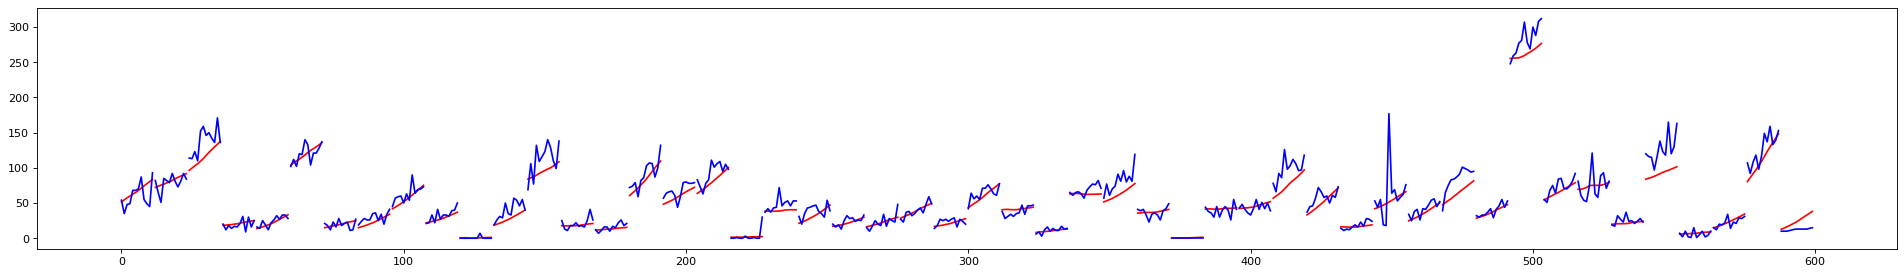

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(30,4), dpi=80)
for i in range(50):
    new_i = i * 12
    plt.plot(range(0+new_i,12+new_i),sample_output[i], color = 'red')
    plt.plot(range(0+new_i,12+new_i),sample_labels[i], color='blue')
plt.show()